In [ ]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install sickit-learn
%pip install imbalanced-learn
%pip install transformers
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [16]:
import kagglehub
import pandas as pd
import os
import warnings
import re
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
warnings.filterwarnings("ignore")

# Download latest version
path = kagglehub.dataset_download("muhammedabdulazeem/500k-stackoverflow-questions")
file_path = os.path.join(path, "questions.csv")

df = pd.read_csv(file_path)

print(f"Numero di righe nel dataset: {df.shape[0]}")

df.head()

Numero di righe nel dataset: 529804


,date,links,questions,tags,time
0,2021-03-24 11:01:18.812726,/questions/66775243/how-to-display-jalali-date...,How to display jalali date in to view in Codei...,"php,codeigniter,date,gregorian-calendar",2 mins ago
1,2021-03-24 11:01:18.814679,/questions/66775242/automate-creating-of-sales...,Automate creating of sales order in Zoho Books,"python-3.x,zohobooks",2 mins ago
2,2021-03-24 11:01:18.817728,/questions/66775240/java-jar-error-for-spring-...,java jar error for spring boot applicaton,"java,spring,spring-boot",3 mins ago
3,2021-03-24 11:01:18.818696,/questions/66775238/not-able-to-run-unfoldingm...,Not able to run UnfoldingMap library,"java,eclipse,dictionary,core,unfoldingmap",3 mins ago
4,2021-03-24 11:01:18.820720,/questions/66775237/serverless-graphql-lambda-...,Serverless Graphql Lambda hard to understand t...,"typescript,webpack,error-handling,graphql,serv...",3 mins ago


# ETL

In [17]:
# Eliminare colonne inutili
df_cleaned = df.drop(columns=['links', 'date', 'time'])

# Rimuovere duplicati
df_cleaned = df_cleaned.drop_duplicates()

# Verificare e gestire dati mancanti
df_cleaned = df_cleaned.dropna()  # Rimuove righe con valori NaN

print(f"Numero di righe nel dataset dopo la pulizia: {df_cleaned.shape[0]}")

df_cleaned.head()

Numero di righe nel dataset dopo la pulizia: 503981


,questions,tags
0,How to display jalali date in to view in Codei...,"php,codeigniter,date,gregorian-calendar"
1,Automate creating of sales order in Zoho Books,"python-3.x,zohobooks"
2,java jar error for spring boot applicaton,"java,spring,spring-boot"
3,Not able to run UnfoldingMap library,"java,eclipse,dictionary,core,unfoldingmap"
4,Serverless Graphql Lambda hard to understand t...,"typescript,webpack,error-handling,graphql,serv..."


In [18]:
def clean_text(text):
    # Rimuove link, caratteri speciali e converte in minuscolo
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)  # Rimuove menzioni e hashtag
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  # Mantiene solo lettere e numeri
    text = text.lower()  # Converte in minuscolo
    text = text.strip()  # Rimuove spazi extra
    return text

# Applicare la pulizia
df_cleaned['questions'] = df_cleaned['questions'].apply(clean_text)

df_cleaned.head()

,questions,tags
0,how to display jalali date in to view in codei...,"php,codeigniter,date,gregorian-calendar"
1,automate creating of sales order in zoho books,"python-3.x,zohobooks"
2,java jar error for spring boot applicaton,"java,spring,spring-boot"
3,not able to run unfoldingmap library,"java,eclipse,dictionary,core,unfoldingmap"
4,serverless graphql lambda hard to understand t...,"typescript,webpack,error-handling,graphql,serv..."


#### tengo solo i tag più frequenti

In [19]:
# Funzione per pulire i tag
def clean_tags(tag_string):
    # Rimuove spazi, split su virgola e filtra stringhe vuote
    tags = [tag.strip() for tag in tag_string.strip('[]').split(',') if tag.strip()]
    return tags

# Applicare la funzione alla colonna 'tags'
df_cleaned['tags'] = df_cleaned['tags'].apply(clean_tags)

# Visualizzare il risultato
df_cleaned.head()

,questions,tags
0,how to display jalali date in to view in codei...,"[php, codeigniter, date, gregorian-calendar]"
1,automate creating of sales order in zoho books,"[python-3.x, zohobooks]"
2,java jar error for spring boot applicaton,"[java, spring, spring-boot]"
3,not able to run unfoldingmap library,"[java, eclipse, dictionary, core, unfoldingmap]"
4,serverless graphql lambda hard to understand t...,"[typescript, webpack, error-handling, graphql,..."


In [20]:
from collections import Counter

# Contare la frequenza di ciascun tag
tag_counter = Counter([tag for tags in df_cleaned['tags'] for tag in tags])

# Mostrare i 20 tag più comuni
most_common_tags = tag_counter.most_common(20)

# Selezionare i top 5000 tag più frequenti
top_tags = [tag for tag, count in tag_counter.most_common(10)]

# Filtrare i tag nel dataset
df_cleaned['tags'] = df_cleaned['tags'].apply(lambda tags: [tag for tag in tags if tag in top_tags])

most_common_tags

[('python', 77678),
 ('javascript', 55810),
 ('java', 28690),
 ('reactjs', 24440),
 ('html', 21462),
 ('c#', 20648),
 ('android', 19108),
 ('php', 17149),
 ('node.js', 16508),
 ('python-3.x', 15050),
 ('r', 14943),
 ('css', 14540),
 ('c++', 13690),
 ('pandas', 12403),
 ('sql', 11633),
 ('flutter', 11025),
 ('angular', 9665),
 ('django', 9395),
 ('typescript', 8991),
 ('arrays', 8695)]

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

# Binarizzare i tag filtrati
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df_cleaned['tags'])

# Creare un DataFrame con i tag codificati
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# Unire i dati codificati con le domande originali
df_encoded = pd.concat([df_cleaned.drop(columns=['tags']), tags_df], axis=1)

# Visualizzare il dataset codificato
df_encoded.head()

,questions,android,c#,html,java,javascript,node.js,php,python,python-3.x,reactjs
0,how to display jalali date in to view in codei...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,automate creating of sales order in zoho books,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,java jar error for spring boot applicaton,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,not able to run unfoldingmap library,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,serverless graphql lambda hard to understand t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


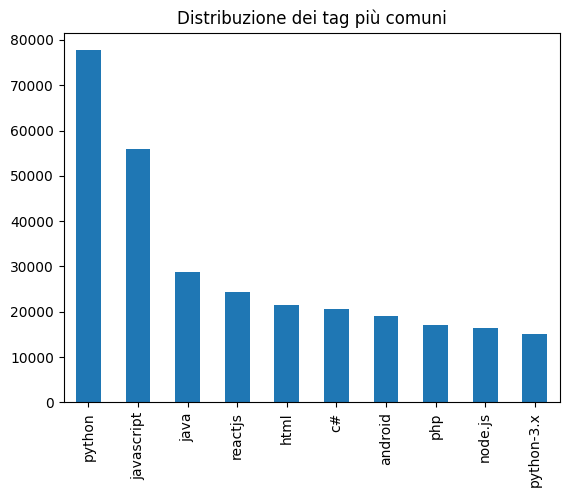

In [22]:
import matplotlib.pyplot as plt

# Contare la frequenza dei tag
tag_counts = tags_df.sum(axis=0).sort_values(ascending=False)

# Visualizzare i primi 10 tag più comuni
tag_counts.head(10).plot(kind='bar', title='Distribuzione dei tag più comuni')
plt.show()

# Classificazione

In [23]:
X = df_encoded['questions']
y = tags_encoded

# Controllare il numero di campioni
print(f"Numero di domande (X): {len(X)}")
print(f"Numero di target (y): {y.shape[0]}")

Numero di domande (X): 528844
Numero di target (y): 503981


In [24]:
# Sincronizzare i dati per il numero minimo di righe
min_samples = min(len(df_encoded), tags_encoded.shape[0])

X = df_encoded['questions'][:min_samples]
y = tags_encoded[:min_samples]

# Controllare il risultato
print(f"Numero di domande sincronizzate (X): {len(X)}")
print(f"Numero di target sincronizzati (y): {y.shape[0]}")

Numero di domande sincronizzate (X): 503981
Numero di target sincronizzati (y): 503981


In [25]:
from sklearn.model_selection import train_test_split

# Dividere in training, validation e test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

Training set: 352786
Validation set: 75597
Test set: 75598


#### Tokenizzazione per BERT

In [26]:
from transformers import BertTokenizer

# Inizializzare il tokenizer di BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Funzione per tokenizzare il dataset con padding e truncation
def tokenize_data(texts, max_length=512):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt",  # Ritorna tensor PyTorch
    )

X_train_encodings = tokenize_data(list(X_train))
X_val_encodings = tokenize_data(list(X_val))
X_test_encodings = tokenize_data(list(X_test))

#### Encoding etichette

In [ ]:
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np

# Convertire da one-hot encoded a array di classi (argmax lungo l'asse delle colonne)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

# Encoding delle etichette
label_encoder = LabelEncoder()

# Trasformare le etichette di training, validation e test
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convertire le etichette in tensori PyTorch
y_train_tensor = torch.tensor(y_train_encoded)
y_val_tensor = torch.tensor(y_val_encoded)
y_test_tensor = torch.tensor(y_test_encoded)

# Stampa di controllo
print("Tokenizzazione completata!")
print(f"Forma dei token di training: {X_train_encodings['input_ids'].shape}")
print(f"Numero di etichette di training: {len(y_train_encoded)}")

#### Creazione Dataset PyTorch

In [29]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Ritorna un singolo elemento per il DataLoader
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Creare i dataset
train_dataset = CustomDataset(X_train_encodings, y_train_tensor)
val_dataset = CustomDataset(X_val_encodings, y_val_tensor)
test_dataset = CustomDataset(X_test_encodings, y_test_tensor)

#### Configurazione DataLoader

In [30]:
from torch.utils.data import DataLoader

# Creare i DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Caricamento modello BERT

In [31]:
from transformers import BertForSequenceClassification

# Caricare il modello pre-addestrato BERT con una testa di classificazione
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_encoder.classes_)  # Numero di classi
)

# Spostare il modello sulla GPU (se disponibile)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### Definizione di Ottimizzatore e Funzione di Perdita

In [32]:
from torch.optim import AdamW

# Ottimizzatore
optimizer = AdamW(model.parameters(), lr=5e-5)

# Funzione di perdita
from torch.nn import CrossEntropyLoss
loss_fn = CrossEntropyLoss()

#### Ciclo di Training

In [33]:
from transformers import get_scheduler
from tqdm import tqdm

# Scheduler per il learning rate
num_training_steps = len(train_loader) * 3  # Epoche
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # Spostare i dati sulla GPU
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Aggiornare il progresso
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

Epoch 0:   1%|          | 127/22050 [00:28<1:20:17,  4.55it/s, loss=1.65]

: 